In [1]:
import tdgl
from tdgl.geometry import box, circle
from tdgl.visualization.animate import create_animation
import numpy as np
import h5py
import os
import matplotlib.pyplot as plt
from IPython.display import HTML, display

In [2]:
def make_video_from_solution(
    solution,
    quantities=("order_parameter"),
    fps=20,
    figsize=(5, 4),
):
    """Generates an HTML5 video from a tdgl.Solution."""
    with tdgl.non_gui_backend():
        with h5py.File(solution.path, "r") as h5file:
            anim = create_animation(
                h5file,
                quantities=quantities,
                fps=fps,
                figure_kwargs=dict(figsize=figsize),
            )
            video = anim.to_html5_video()
        return HTML(video)

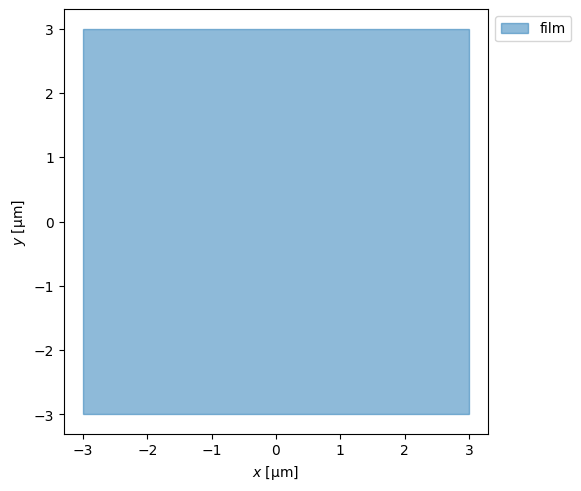

In [3]:
# Make Layer
length_units = 'um'

# Material parameters
xi = 1/3
london_lambda = 2
d = 0.1
layer = tdgl.Layer(coherence_length=xi, london_lambda=london_lambda, thickness=d, gamma=1)

# Device geometry
total_width = 6
total_length = 6

# Outer geometry of the film
film = (
    tdgl.Polygon("film", points=box(total_width, total_length))
    .resample(401)
    .buffer(0)
)

#film = (tdgl.Polygon("film", points=circle(radius=total_width/2)).resample(401).buffer(0))

device = tdgl.Device(
    "weak_link",
    layer=layer,
    film=film,
    length_units=length_units,
)

fig, ax = device.draw()

Constructing Voronoi polygons: 100%|██████████| 4733/4733 [00:01<00:00, 2390.84it/s]


num_sites,4733
num_elements,9064
min_edge_length,3.888e-02
max_edge_length,1.568e-01
mean_edge_length,9.490e-02
min_area,8.159e-04
max_area,1.631e-02
mean_area,7.606e-03
coherence_length,3.333e-01
length_units,um


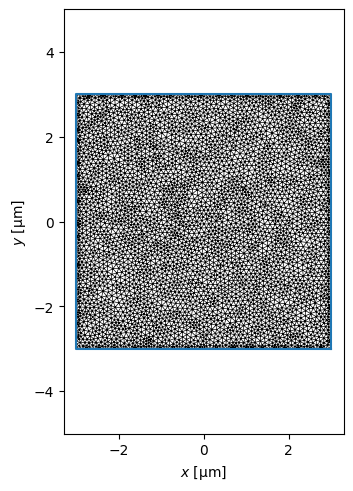

In [4]:
# Finite Volume Method
device.make_mesh(max_edge_length=xi / 2, smooth=100)
fig, ax = device.plot(mesh=True, legend=False)
_ = ax.set_ylim(-5, 5)
device.mesh_stats()

In [5]:
#funtions for external fields
def time_factor(x, y, z, *, t, setpoints):
    '''
    A functions that characterize the time dependence of the magnetic field. You can turn it into the 'Parameter' class 
    of tdgl package by 'tdgl.Parameter(time_factor, setpoints=setpoints, time_dependent=True)'.
    For more details and usage of please refer to the 'Parameter' class.
    Args:
        setpoints: Setpoints for External fields, should be like np.array([[t1, B1], ..., [tN, BN]]), with shape (N,2)
    '''
    if t < setpoints[0, 0]:
        return setpoints[0, 1]
    elif t >= setpoints[-1, 0]:
        return setpoints[-1, 1]
    else:
        for i in range(len(setpoints)):
            ti, Bi = setpoints[i]
            tf, Bf = setpoints[i+1]
            Bi, Bf = float(Bi), float(Bf)
            if ti <= t < tf:
                return Bi + (Bf-Bi)*(t-ti)/(tf-ti)

def plot_time_factor(setpoints, field_unit):
    '''
    Plot the time factor as a function of t, that is, plot the time dependency of the magnetic field.
    '''
    ti = setpoints[0, 0]
    tf = setpoints[-1, 0]
    T = np.linspace(ti, tf, max(100, 5*len(setpoints)))
    B = np.zeros_like(T)
    for i in range(len(T)):
        t = T[i]
        B[i] = time_factor(0, 0, 0, t=t, setpoints=setpoints)
    plt.plot(T, B)
    plt.ylabel('B/{unit}'.format(unit=field_unit))
    plt.xlabel('Time/s')
    plt.show()

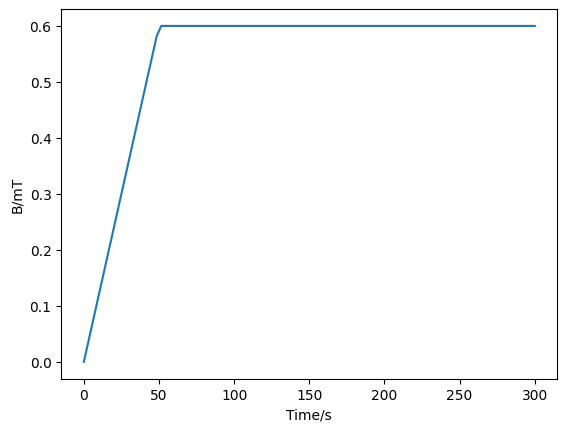

Simulating: 100%|█████████▉| 300/300 [01:01<00:00,  4.88tau/s ]
Exception in thread Thread-7 (_readerthread):
Traceback (most recent call last):
  File "d:\Anaconda3\envs\tdgl\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "d:\Anaconda3\envs\tdgl\lib\site-packages\ipykernel\ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "d:\Anaconda3\envs\tdgl\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "d:\Anaconda3\envs\tdgl\lib\subprocess.py", line 1515, in _readerthread
    buffer.append(fh.read())
  File "d:\Anaconda3\envs\tdgl\lib\codecs.py", line 322, in decode
    (result, consumed) = self._buffer_decode(data, self.errors, final)
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xb5 in position 30: invalid start byte
d:\Anaconda3\envs\tdgl\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
'NoneTyp

In [6]:
#External Field and Simualtion options
options = tdgl.SolverOptions(
    # Allow some time to equilibrate before saving data.
    solve_time=300,
    output_file=os.path.join('solutions', "example.h5"),
    field_units = "mT",
    current_units="uA",
    save_every=100,
)

from tdgl.sources import ConstantField

#Setpoints for External fields, should be like np.array([[t1, B1], ..., [tN, BN]]), with shape (N,2)
setpoints_pos = np.array([[0, 50, 300],
                      [0, 0.6, 0.6]])
setpoints = setpoints_pos.T
plot_time_factor(setpoints=setpoints, field_unit=options.field_units)

#Turn time_factor into Parameter named t_dependence and multiply it by the ConstantField
t_dependence = tdgl.Parameter(time_factor, setpoints=setpoints, time_dependent=True)
applied_vector_potential = ConstantField(1.0, field_units=options.field_units, length_units=device.length_units) * t_dependence

#Tune the temperature
'''
def disorder_epsilon(r, *, t):
    if t < 300:
        return 0
    elif t >= 300:
        return 1
'''

#seed to start with
'''
seed_solution = tdgl.Solution.from_hdf5(r'solutions\0816\seed_300.h5')
device = seed_solution.device
'''

zero_current_solution = tdgl.solve(
    device,
    options,
    applied_vector_potential=applied_vector_potential,
    #disorder_epsilon=disorder_epsilon,
    #seed_solution=seed_solution,
)

Time: 0.0s  Field: 0.00mT


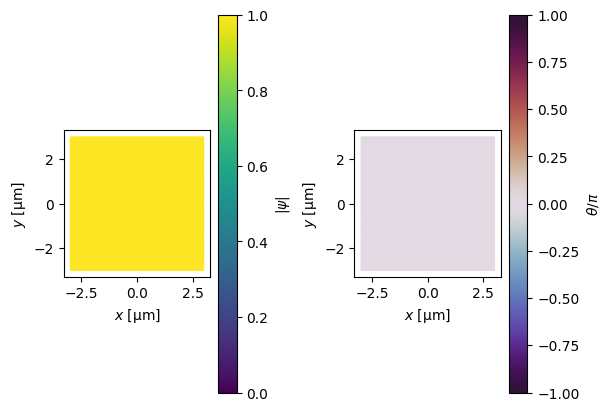

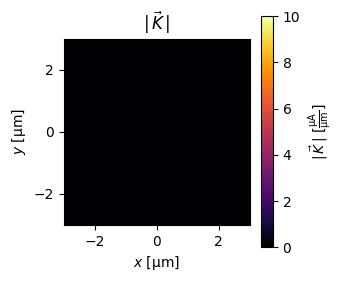

Time: 99.6s  Field: 0.60mT


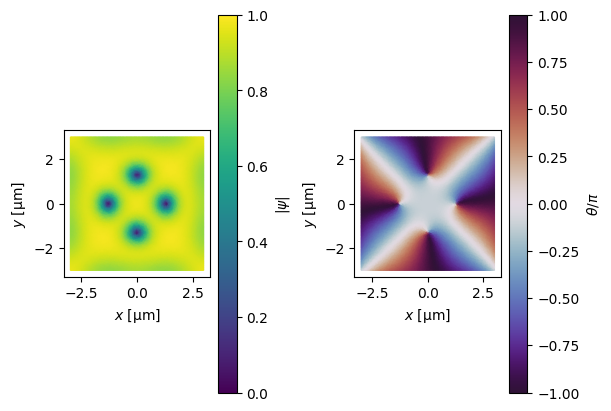

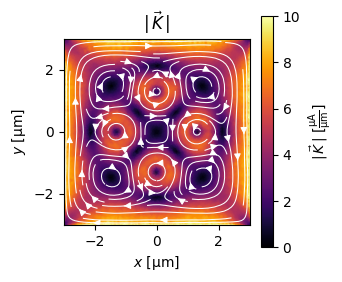

Time: 200.5s  Field: 0.60mT


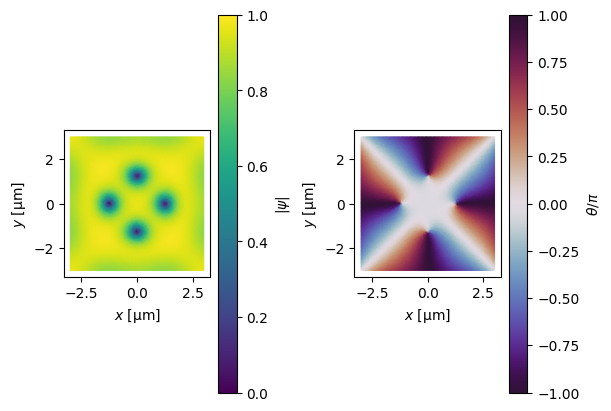

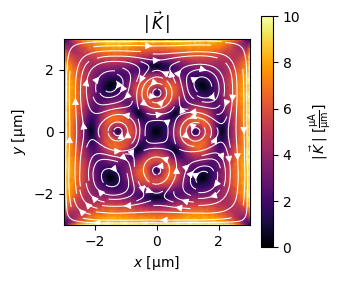

Time: 300.1s  Field: 0.60mT


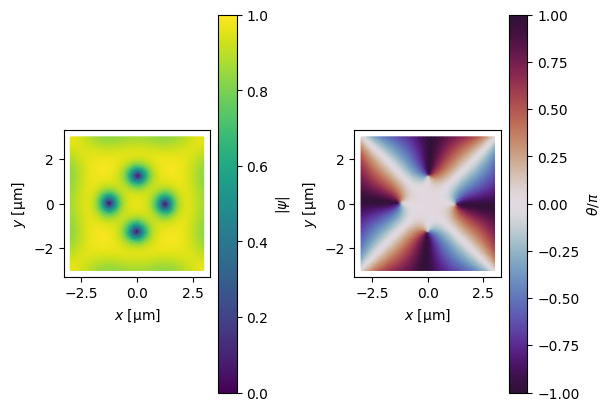

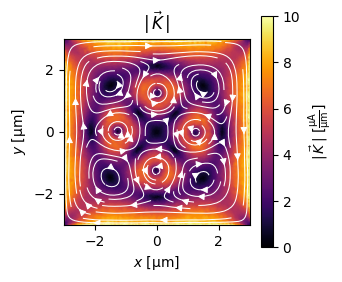

In [7]:
#Plot order parameter and current at certain time
def plot_simulations_of_times(solution, setpoints):
    '''
    Plot the order parameter and current at the time that is closest to the given time points.
    '''
    for time in setpoints:
        # find the solve step that is closest to the given time
        step = solution.closest_solve_step(time)
        # find the exact time corressponding to the solve step
        exact_time = solution.times[step]
        # load the solution of certain solve step
        solution.load_tdgl_data(step)

        # The applied field is actually vector potential A, the following step recover external magnetic field B from A
        A = solution.applied_vector_potential(np.array([-1, 1]), np.array([-1, 1]), np.array([0, 0]), t=exact_time)
        Bz = A[0, 0] - A[1, 0]

        print('Time: {exact_time:.1f}s  Field: {field:.2f}{unit}'.format(exact_time = solution.times[step], field = Bz, unit=solution.field_units))
        fig, axes = solution.plot_order_parameter(figsize=(6, 4))
        solution.plot_currents(min_stream_amp=0.075, vmin=0, vmax=10, figsize = (3,3))

        plt.show()

samples = range(0, 301, 100)

plot_simulations_of_times(zero_current_solution, samples)

In [8]:
# Make Video
zero_field_video = make_video_from_solution(
        zero_current_solution,
        quantities=["order_parameter", "phase", "scalar_potential"],
        figsize=(6.5, 4),
    )
display(zero_field_video)